# LP4 Assignment 4
## Sudeep Mangalvedhekar
## 43147

In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from matplotlib import pyplot as plt

In [73]:
def load_dataset():
  dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
  raw_data = dataframe.values

  labels = raw_data[:, -1]
  data = raw_data[:, 0 : -1]

  train_data, test_data, train_labels, test_labels = train_test_split(
      data, labels, test_size = 0.2, random_state = 21
  )
  return [train_data, train_labels, test_data, test_labels]

In [74]:
def normalize(train_data, test_data):
  min_max_scaler = MinMaxScaler(feature_range=(0, 1))
  train_data = min_max_scaler.fit_transform(train_data)
  test_data = min_max_scaler.transform(test_data)
  return [train_data, test_data]

In [75]:
def pre_process_data(train_data, test_data, train_labels, test_labels):
  train_labels = train_labels.astype(bool)
  test_labels = test_labels.astype(bool)

  normal_train_data = train_data[train_labels]
  normal_test_data = test_data[test_labels]

  anomalous_train_data = train_data[~train_labels]
  anomalous_test_data = test_data[~test_labels]
  return [normal_train_data, normal_test_data, anomalous_train_data, anomalous_test_data]

In [76]:
def model_def():
  class AnomalyDetector(Model):
    def __init__(self):
      super(AnomalyDetector, self).__init__()
      self.encoder = tf.keras.Sequential([
        tfl.Dense(32, activation = "relu"),
        tfl.Dense(16, activation = "relu"),
        tfl.Dense(8, activation = "relu")])

      self.decoder = tf.keras.Sequential([
        tfl.Dense(16, activation = "relu"),
        tfl.Dense(32, activation = "relu"),
        tfl.Dense(140, activation = "sigmoid")])

    def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

  autoencoder = AnomalyDetector()
  autoencoder.compile(optimizer = 'adam', loss = 'mse')
  return autoencoder

In [77]:
def train_model():
  # load data
  train_data, train_labels, test_data, test_labels = load_dataset()
  # normalize data
  train_data, test_data = normalize(train_data, test_data)
  # pre process data
  normal_train_data, normal_test_data, anomalous_train_data, anomalous_test_data = pre_process_data(train_data, test_data, train_labels, test_labels)

  model = model_def()
  model_history = model.fit(normal_train_data, normal_train_data, epochs = 20, batch_size = 512, shuffle = True)
  return [model, model_history, normal_train_data, normal_test_data, test_data, test_labels]

In [78]:
def plot_performance(model_history):
  plt.title("Training Loss")
  plt.plot(model_history.history["loss"])
  plt.show()

In [79]:
# train model
model, model_history, normal_train_data, normal_test_data, test_data, test_labels = train_model()

Epoch 1/20
5/5 [==============================] - 1s 7ms/step - loss: 0.0255
Epoch 2/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0236
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 4/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 5/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0159
Epoch 6/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0133
Epoch 7/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0111
Epoch 8/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0094
Epoch 9/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0080
Epoch 10/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0071
Epoch 11/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 12/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 13/20
5/5 [==============================] - 0s 6ms/step - loss: 0.

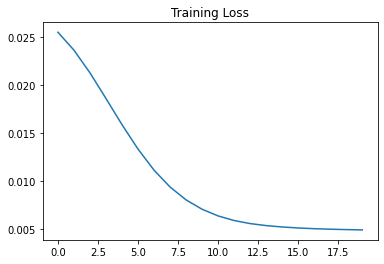

In [80]:
# plot performance
plot_performance(model_history)

In [81]:
def define_threshold(normal_train_data):
  reconstructions = model.predict(normal_train_data)
  train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
  threshold = np.mean(train_loss) + np.std(train_loss)
  return threshold

In [82]:
def detect_anomaly(threshold, test_data):
  reconstructions = model(test_data)
  loss = tf.keras.losses.mae(reconstructions, test_data)
  return tf.math.less(loss, threshold)

In [83]:
def evaluate_model(prediction, test_labels):
  print("Accuracy = {}".format(accuracy_score(test_labels, prediction)))
  print("Precision = {}".format(precision_score(test_labels, prediction)))
  print("Recall = {}".format(recall_score(test_labels, prediction)))

In [84]:
# get threshold
threshold = define_threshold(normal_train_data)
# detect anomaly
prediction = detect_anomaly(threshold, test_data)

74/74 [==============================] - 0s 1ms/step


In [85]:
# evaluate model
evaluate_model(prediction, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571
